STEP 1: Data Loading and Preprocessing
  https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+toi&forma...
 -> Got 7703 rows, 91 cols

Final cleaned dataset: (2562, 17)

Class balance (Full dataset):
  0.0: 1295 (50.5%)
  1.0: 1267 (49.5%)

STEP 2: Data Splitting

Train: 1792 (69.9%)
Val:   513 (20.0%)
Test:  257 (10.0%)

Class balance (Train):
  0: 906 (50.6%)
  1: 886 (49.4%)

Class balance (Val):
  0: 259 (50.5%)
  1: 254 (49.5%)

Class balance (Test):
  0: 130 (50.6%)
  1: 127 (49.4%)

STEP 3: Preprocessing
✓ Data preprocessed (imputation + scaling)

STEP 4: Hyperparameter Tuning

[1/2] Tuning LightGBM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✓ Best LGB ROC AUC: 0.920
Best LGB params:
{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': -1,
 'n_estimators': 200,
 'num_leaves': 31,
 'subsample': 1.0}

[2/2] Tuning Gradient Boosting...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

✓ Best GB ROC AUC: 0.924
Best GB p

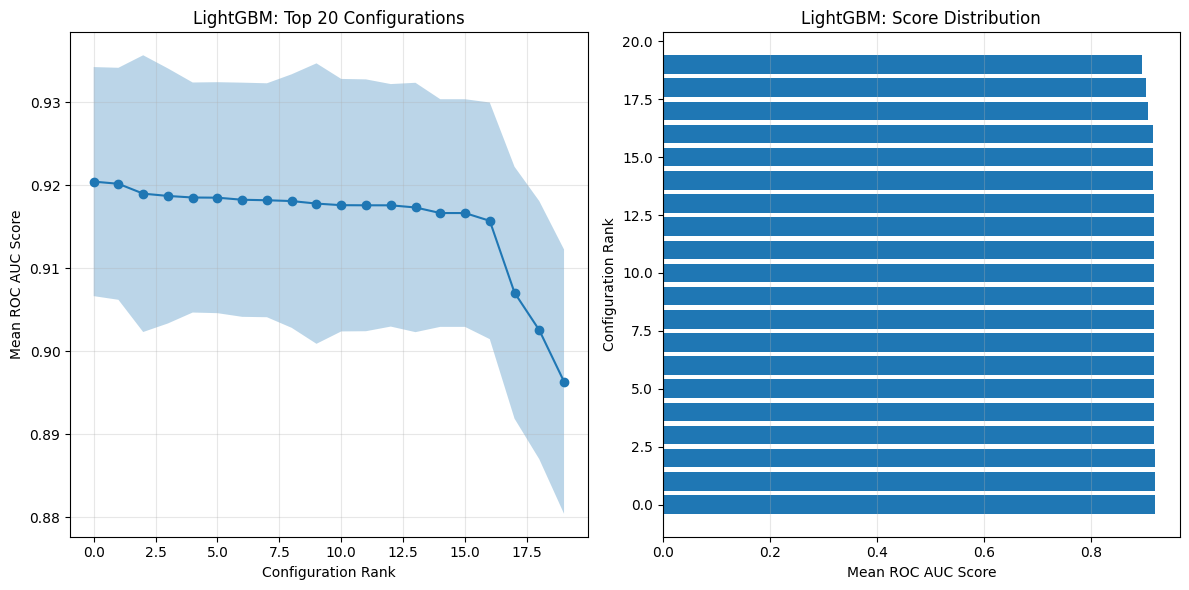

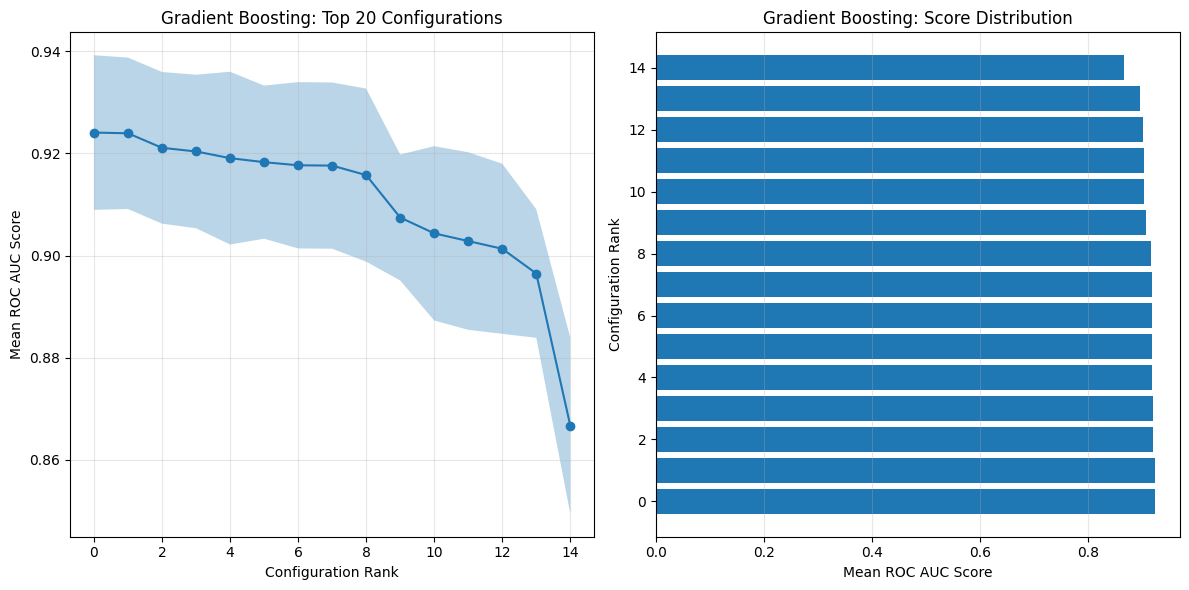


Feature Importance Analysis...


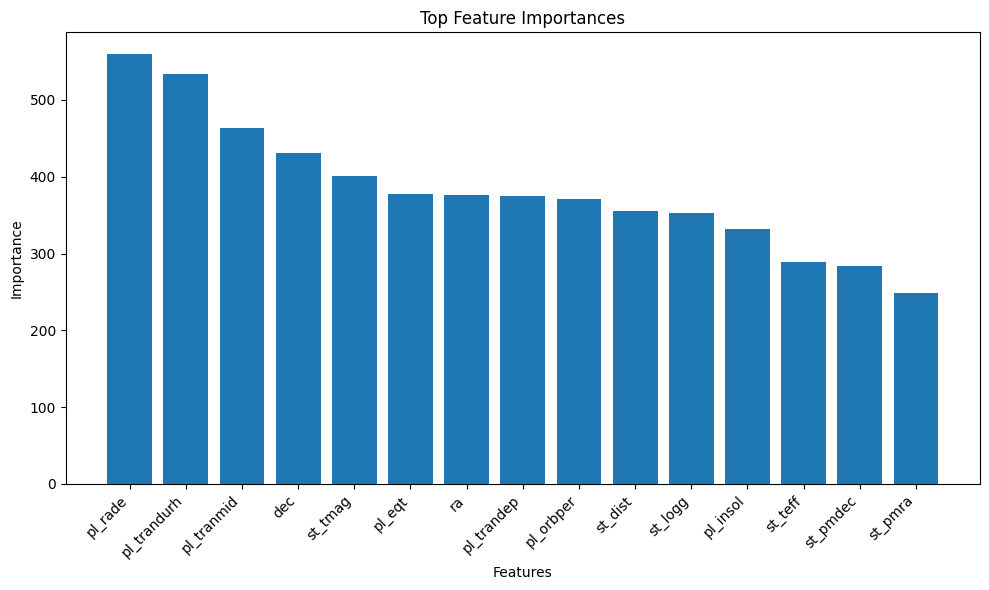


STEP 6: Stacking Ensemble
Training stacking classifier...
✓ Stacking model trained

STEP 7: Validation Evaluation

Validation Metrics
Accuracy : 0.838
Precision: 0.815
Recall   : 0.870
F1 Score : 0.842
ROC AUC  : 0.927
Brier    : 0.114

Confusion Matrix:
  TN:  209  |  FP:   50
  FN:   33  |  TP:  221

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       259
           1       0.82      0.87      0.84       254

    accuracy                           0.84       513
   macro avg       0.84      0.84      0.84       513
weighted avg       0.84      0.84      0.84       513


Generating learning curves...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


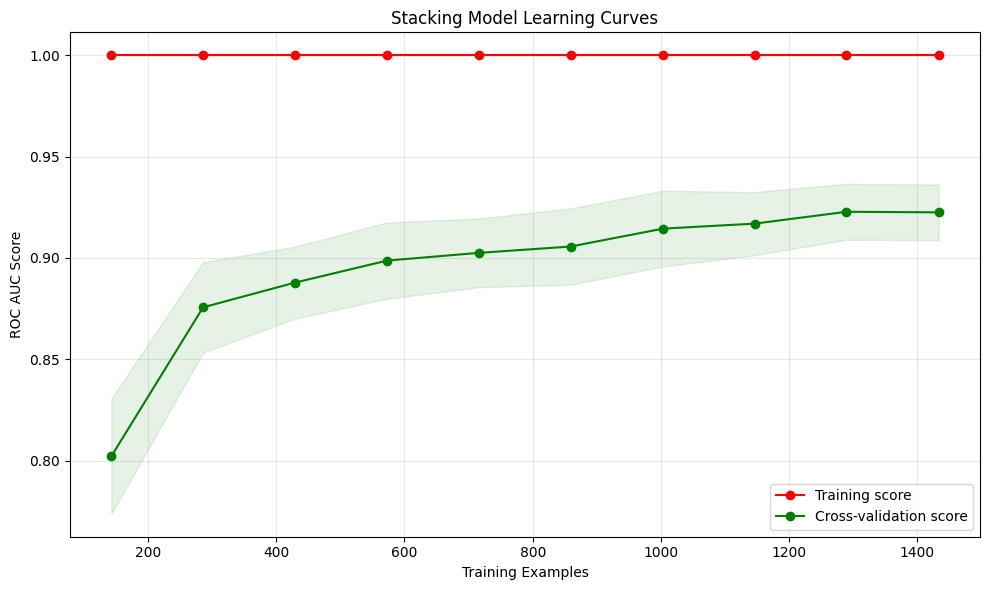


STEP 8: Final Model Training
Training final model on train+val data...
✓ Final model trained

STEP 9: Test Set Evaluation

Test Set Metrics
Accuracy : 0.872
Precision: 0.867
Recall   : 0.874
F1 Score : 0.871
ROC AUC  : 0.949
Brier    : 0.092

Confusion Matrix:
  TN:  113  |  FP:   17
  FN:   16  |  TP:  111

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       130
           1       0.87      0.87      0.87       127

    accuracy                           0.87       257
   macro avg       0.87      0.87      0.87       257
weighted avg       0.87      0.87      0.87       257


Comparing model performance...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


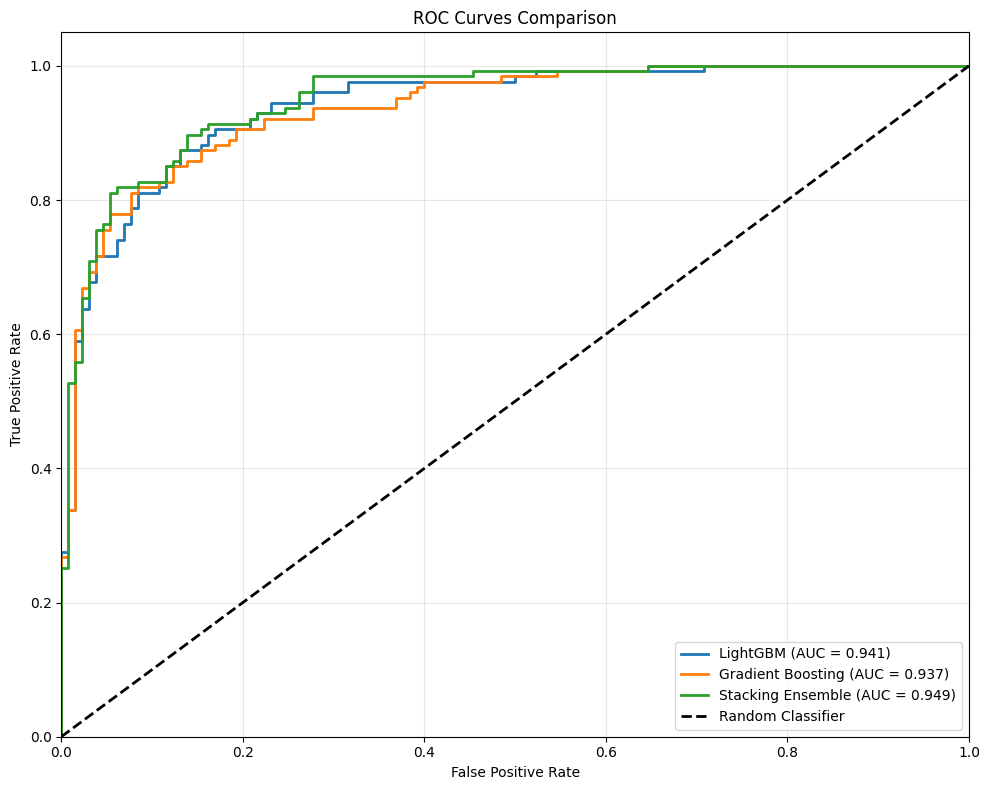


STEP 10: Save Model Pipeline
✅ Saved model pipeline to 'toi_stacking_pipeline.joblib'

TRAINING COMPLETE - SUMMARY
Features used: 16
Training samples: 1792
Validation samples: 513
Test samples: 257

Final Test Performance:
  ROC AUC: 0.949
  F1 Score: 0.871
  Accuracy: 0.872


In [ ]:
# -*- coding: utf-8 -*-
"""Enhanced TOI Exoplanet Classifier with Training Visualization"""

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import joblib
import re

# Modeling + ML
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    brier_score_loss, roc_curve, auc
)
from lightgbm import LGBMClassifier

# Settings
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
pd.set_option("display.max_columns", 100)

# ============ CONFIGURATION ============
# Features to use for training
FEATURES = [
    'pl_orbper',    # Orbital Period
    'pl_trandurh',   # Transit Duration
    'pl_rade',      # Candidate Radius
    'st_dist',      # Distance to system
    'st_pmdec',     # Proper Motion (Dec)
    'st_pmra',      # Proper Motion (RA)
    'dec',          # Declination
    'pl_insol',     # Insolation Flux
    'pl_tranmid',   # Transit Midpoint
    'ra',           # Right Ascension
    'st_tmag',      # TESS Magnitude
    'pl_trandep',   # Transit Depth
    'pl_eqt',       # Equilibrium Temperature
    'st_rad',
    'st_logg',      # Stellar Surface Gravity
    'st_teff'       # Effective Temperature
]

LABEL_COL = 'tfopwg_disp'  # Disposition column
USER_URL = 'https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+toi+where+tfopwg_disp=%27CP%27&format=csv'
FALLBACK_URL = 'https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+toi&format=csv'

# ============ HELPER FUNCTIONS ============
def fetch_csv(url):
    print(f"Downloading from:\n  {url[:80]}...")
    df = pd.read_csv(url)
    print(f" -> Got {df.shape[0]} rows, {df.shape[1]} cols")
    return df


def map_disp_to_label(s):
    """Map disposition string to binary label."""
    if pd.isna(s):
        return np.nan
    su = str(s).upper()
    if "CONFIRMED" in su or su.strip() == "CP" or su.strip() == "KP":
        return 1
    if "FALSE" in su or su.strip() == "FP" or su.strip() == "FA":
        return 0
    return np.nan


def print_class_balance(y, label="data"):
    vals, counts = np.unique(y, return_counts=True)
    print(f"\nClass balance ({label}):")
    for v, c in zip(vals, counts):
        print(f"  {v}: {c} ({c/len(y):.1%})")


def plot_learning_curves(estimator, X, y, title="Learning Curves", cv=5):
    """Plot learning curves to visualize training progress."""
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='roc_auc', random_state=RANDOM_SEED
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, val_mean, 'o-', color='g', label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')

    plt.xlabel('Training Examples')
    plt.ylabel('ROC AUC Score')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_roc_curves(models_dict, X_test, y_test):
    """Plot ROC curves for multiple models."""
    plt.figure(figsize=(10, 8))

    for name, model in models_dict.items():
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_feature_importance(model, feature_names, top_n=15):
    """Plot feature importance for the best LightGBM model."""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:top_n]

        plt.figure(figsize=(10, 6))
        plt.title('Top Feature Importances')
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()


def plot_training_history(rs_model, model_name="Model"):
    """Plot hyperparameter search results."""
    results = pd.DataFrame(rs_model.cv_results_)
    results = results.sort_values('mean_test_score', ascending=False).head(20)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(results)), results['mean_test_score'], 'o-')
    plt.fill_between(range(len(results)),
                     results['mean_test_score'] - results['std_test_score'],
                     results['mean_test_score'] + results['std_test_score'],
                     alpha=0.3)
    plt.xlabel('Configuration Rank')
    plt.ylabel('Mean ROC AUC Score')
    plt.title(f'{model_name}: Top 20 Configurations')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.barh(range(len(results)), results['mean_test_score'])
    plt.xlabel('Mean ROC AUC Score')
    plt.ylabel('Configuration Rank')
    plt.title(f'{model_name}: Score Distribution')
    plt.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()


def evaluate_model(y_true, y_pred, y_proba, tag="Validation"):
    """Evaluate model and print metrics."""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred)
    auc_ = roc_auc_score(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n{'='*50}")
    print(f"{tag} Metrics")
    print('='*50)
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1 Score : {f1:.3f}")
    print(f"ROC AUC  : {auc_:.3f}")
    print(f"Brier    : {brier:.3f}")
    print(f"\nConfusion Matrix:")
    print(f"  TN: {cm[0,0]:4d}  |  FP: {cm[0,1]:4d}")
    print(f"  FN: {cm[1,0]:4d}  |  TP: {cm[1,1]:4d}")
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred))
    return dict(acc=acc, prec=prec, rec=rec, f1=f1, auc=auc_, brier=brier)


# ============ DATA LOADING ============
print("="*60)
print("STEP 1: Data Loading and Preprocessing")
print("="*60)

df = fetch_csv(FALLBACK_URL)

if LABEL_COL not in df.columns:
    raise ValueError(f"Column {LABEL_COL} not found.")

# Map label
df["label_raw"] = df[LABEL_COL]
df["label"] = df["label_raw"].apply(map_disp_to_label)

# Check available features
available_features = [f for f in FEATURES if f in df.columns]
missing_features = [f for f in FEATURES if f not in df.columns]

if missing_features:
    print(f"\n⚠️  Warning: Missing features: {missing_features}")
    print(f"✓  Using {len(available_features)} available features")
    FEATURES = available_features

# Keep only numeric columns + label
df = df[FEATURES + ["label"]]
df = df.apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=["label"])
df = df.dropna(how="all", subset=FEATURES).reset_index(drop=True)

print(f"\nFinal cleaned dataset: {df.shape}")
print_class_balance(df["label"], "Full dataset")

# ============ TRAIN/VAL/TEST SPLIT ============
print("\n" + "="*60)
print("STEP 2: Data Splitting")
print("="*60)

X = df[FEATURES]
y = df["label"].astype(int)

# First split test (10%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_SEED, stratify=y
)

# Then split validation (20% of total)
val_frac = 0.2 / 0.9
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_frac, random_state=RANDOM_SEED, stratify=y_trainval
)

print(f"\nTrain: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val:   {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test:  {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print_class_balance(y_train, "Train")
print_class_balance(y_val, "Val")
print_class_balance(y_test, "Test")

# ============ PREPROCESSING ============
print("\n" + "="*60)
print("STEP 3: Preprocessing")
print("="*60)

preprocessor = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

X_train_p = preprocessor.fit_transform(X_train)
X_val_p = preprocessor.transform(X_val)
X_test_p = preprocessor.transform(X_test)
print("✓ Data preprocessed (imputation + scaling)")

# ============ MODEL TRAINING ============
print("\n" + "="*60)
print("STEP 4: Hyperparameter Tuning")
print("="*60)

# LightGBM tuning
print("\n[1/2] Tuning LightGBM...")
param_lgb = {
    "n_estimators": [200, 400, 800,1600,3200],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves": [15, 31, 63],
    "max_depth": [-1, 5, 10],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
}
lgb = LGBMClassifier(random_state=RANDOM_SEED, verbose=-1)
rs_lgb = RandomizedSearchCV(
    lgb, param_distributions=param_lgb, n_iter=20,
    scoring="roc_auc", cv=5, random_state=RANDOM_SEED, n_jobs=-1, verbose=1
)
rs_lgb.fit(X_train_p, y_train)
best_lgb = rs_lgb.best_estimator_
print(f"\n✓ Best LGB ROC AUC: {rs_lgb.best_score_:.3f}")
print("Best LGB params:")
pprint(rs_lgb.best_params_)

# Gradient Boosting tuning
print("\n[2/2] Tuning Gradient Boosting...")
param_gb = {
    "n_estimators": [100, 200, 400,800],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5],
    "subsample": [0.8, 1.0]
}
gb = GradientBoostingClassifier(random_state=RANDOM_SEED)
rs_gb = RandomizedSearchCV(
    gb, param_distributions=param_gb, n_iter=15,
    scoring="roc_auc", cv=5, random_state=RANDOM_SEED, n_jobs=-1, verbose=1
)
rs_gb.fit(X_train_p, y_train)
best_gb = rs_gb.best_estimator_
print(f"\n✓ Best GB ROC AUC: {rs_gb.best_score_:.3f}")
print("Best GB params:")
pprint(rs_gb.best_params_)

# ============ VISUALIZATION: TRAINING PROCESS ============
print("\n" + "="*60)
print("STEP 5: Training Visualization")
print("="*60)

# Plot hyperparameter search results
plot_training_history(rs_lgb, "LightGBM")
plot_training_history(rs_gb, "Gradient Boosting")

# Plot feature importance
print("\nFeature Importance Analysis...")
plot_feature_importance(best_lgb, FEATURES)

# ============ STACKING ENSEMBLE ============
print("\n" + "="*60)
print("STEP 6: Stacking Ensemble")
print("="*60)

stack = StackingClassifier(
    estimators=[("lgbm", best_lgb), ("gb", best_gb)],
    final_estimator=LogisticRegression(max_iter=5000),
    n_jobs=-1,
    cv=5
)
print("Training stacking classifier...")
stack.fit(X_train_p, y_train)
print("✓ Stacking model trained")

# ============ VALIDATION EVALUATION ============
print("\n" + "="*60)
print("STEP 7: Validation Evaluation")
print("="*60)

y_val_pred = stack.predict(X_val_p)
y_val_proba = stack.predict_proba(X_val_p)[:, 1]
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, "Validation")

# Plot learning curves
print("\nGenerating learning curves...")
plot_learning_curves(stack, X_train_p, y_train, "Stacking Model Learning Curves")

# ============ FINAL MODEL TRAINING ============
print("\n" + "="*60)
print("STEP 8: Final Model Training")
print("="*60)

# Combine train + val
X_trainval_p = np.vstack([X_train_p, X_val_p])
y_trainval = np.concatenate([y_train, y_val])

stack_final = StackingClassifier(
    estimators=[("lgbm", best_lgb), ("gb", best_gb)],
    final_estimator=LogisticRegression(max_iter=5000),
    n_jobs=-1,
    cv=5
)
print("Training final model on train+val data...")
stack_final.fit(X_trainval_p, y_trainval)
print("✓ Final model trained")

# ============ TEST EVALUATION ============
print("\n" + "="*60)
print("STEP 9: Test Set Evaluation")
print("="*60)

y_test_pred = stack_final.predict(X_test_p)
y_test_proba = stack_final.predict_proba(X_test_p)[:, 1]
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, "Test Set")

# Plot ROC curves comparison
print("\nComparing model performance...")
models_dict = {
    'LightGBM': best_lgb,
    'Gradient Boosting': best_gb,
    'Stacking Ensemble': stack_final
}
plot_roc_curves(models_dict, X_test_p, y_test)

# ============ SAVE MODEL ============
print("\n" + "="*60)
print("STEP 10: Save Model Pipeline")
print("="*60)

final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", stack_final)
])

joblib.dump(final_pipeline, "toi_stacking_pipeline.joblib")
print("✅ Saved model pipeline to 'toi_stacking_pipeline.joblib'")

# Print summary
print("\n" + "="*60)
print("TRAINING COMPLETE - SUMMARY")
print("="*60)
print(f"Features used: {len(FEATURES)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"\nFinal Test Performance:")
print(f"  ROC AUC: {test_metrics['auc']:.3f}")
print(f"  F1 Score: {test_metrics['f1']:.3f}")
print(f"  Accuracy: {test_metrics['acc']:.3f}")
print("="*60)

In [ ]:
# ============ FEATURE DIRECTION ANALYSIS ============
print("\n" + "="*60)
print("Feature Impact Direction Analysis")
print("="*60)

# 1. Simple correlation with target
correlations = df[FEATURES].corrwith(df['label']).sort_values(ascending=False)
print("\nFeature Correlations with Target (Confirmed Planet):")
print("Positive = Higher value → Higher probability of confirmation")
print("Negative = Higher value → Lower probability of confirmation\n")
for feat, corr in correlations.items():
    direction = "↑" if corr > 0 else "↓"
    print(f"  {feat:20s}: {corr:+.4f} {direction}")

# 2. Analyze feature values for each class
print("\n" + "="*60)
print("Mean Feature Values by Class")
print("="*60)
comparison = pd.DataFrame({
    'False_Positive_Mean': df[df['label']==0][FEATURES].mean(),
    'Confirmed_Planet_Mean': df[df['label']==1][FEATURES].mean(),
})
comparison['Difference'] = comparison['Confirmed_Planet_Mean'] - comparison['False_Positive_Mean']
comparison['Direction'] = comparison['Difference'].apply(lambda x: 'Higher→Confirmed' if x > 0 else 'Lower→Confirmed')
print(comparison.sort_values('Difference', ascending=False))

# 3. Get SHAP-like importance from the meta-learner (Logistic Regression)
print("\n" + "="*60)
print("Meta-Learner (Logistic Regression) Coefficients")
print("="*60)
meta_lr = stack_final.final_estimator_
print("Base model predictions → Final prediction weights:")
for i, (name, _) in enumerate(stack_final.estimators):
    coef = meta_lr.coef_[0][i] if len(meta_lr.coef_[0]) > i else 0
    print(f"  {name:20s}: {coef:+.4f}")


Feature Impact Direction Analysis

Feature Correlations with Target (Confirmed Planet):
Positive = Higher value → Higher probability of confirmation
Negative = Higher value → Lower probability of confirmation

  st_logg             : +0.2756 ↑
  pl_tranmid          : +0.1422 ↑
  pl_trandurh         : +0.0703 ↑
  pl_trandep          : +0.0262 ↑
  ra                  : +0.0025 ↑
  pl_orbper           : -0.0003 ↓
  dec                 : -0.0119 ↓
  st_pmra             : -0.0142 ↓
  st_tmag             : -0.0153 ↓
  st_pmdec            : -0.0980 ↓
  pl_rade             : -0.1248 ↓
  st_rad              : -0.1536 ↓
  pl_insol            : -0.1999 ↓
  st_dist             : -0.2188 ↓
  st_teff             : -0.2817 ↓
  pl_eqt              : -0.3956 ↓

Mean Feature Values by Class
             False_Positive_Mean  Confirmed_Planet_Mean   Difference  \
pl_trandep          7.832815e+03           8.971526e+03  1138.710537   
pl_tranmid          2.459318e+06           2.459508e+06   190.585374   

STEP 1: Data Loading and Preprocessing
  https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+toi&forma...
 -> Got 7703 rows, 91 cols

Final cleaned dataset: (2562, 17)

Class balance (Full dataset):
  0.0: 1295 (50.5%)
  1.0: 1267 (49.5%)

STEP 2: Data Splitting

Train: 1792 (69.9%)
Val:   513 (20.0%)
Test:  257 (10.0%)

Class balance (Train):
  0: 906 (50.6%)
  1: 886 (49.4%)

Class balance (Val):
  0: 259 (50.5%)
  1: 254 (49.5%)

Class balance (Test):
  0: 130 (50.6%)
  1: 127 (49.4%)

STEP 3: Preprocessing
✓ Data preprocessed (imputation + scaling)

STEP 4: Hyperparameter Tuning

[1/2] Tuning XGBoost...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:57:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✓ Best XGBoost ROC AUC: 0.922
Best XGBoost params:
{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 800,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'subsample': 0.7}

[2/2] Tuning Secondary XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:58:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✓ Best Secondary XGBoost ROC AUC: 0.922
Best Secondary XGBoost params:
{'colsample_bytree': 0.75,
 'learning_rate': 0.02,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 600,
 'subsample': 0.75}

STEP 5: Training Visualization


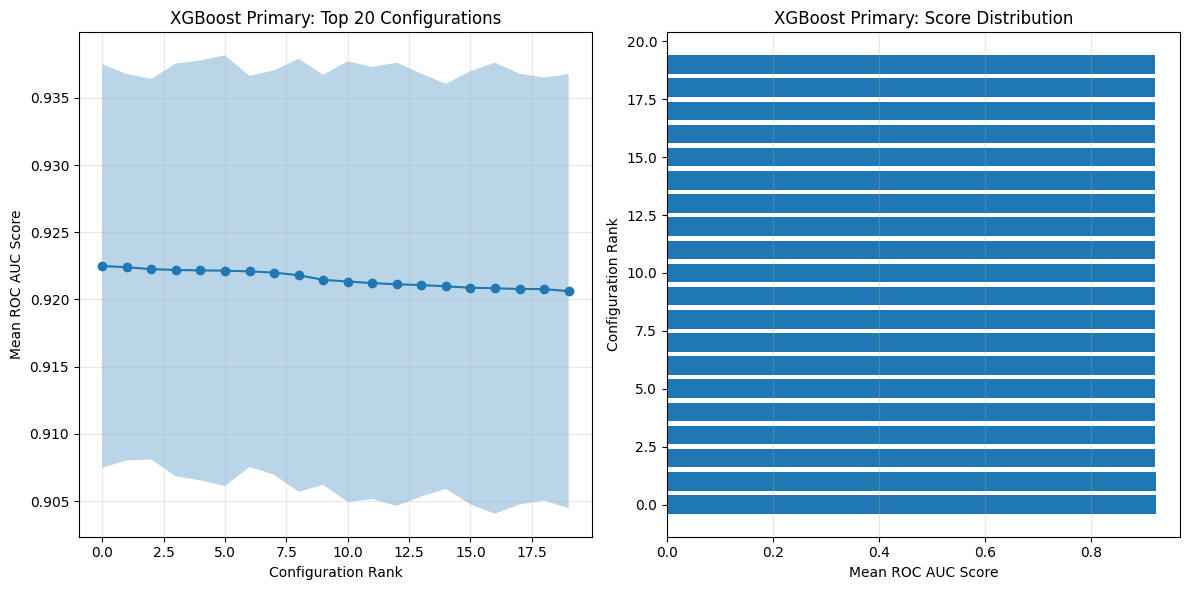

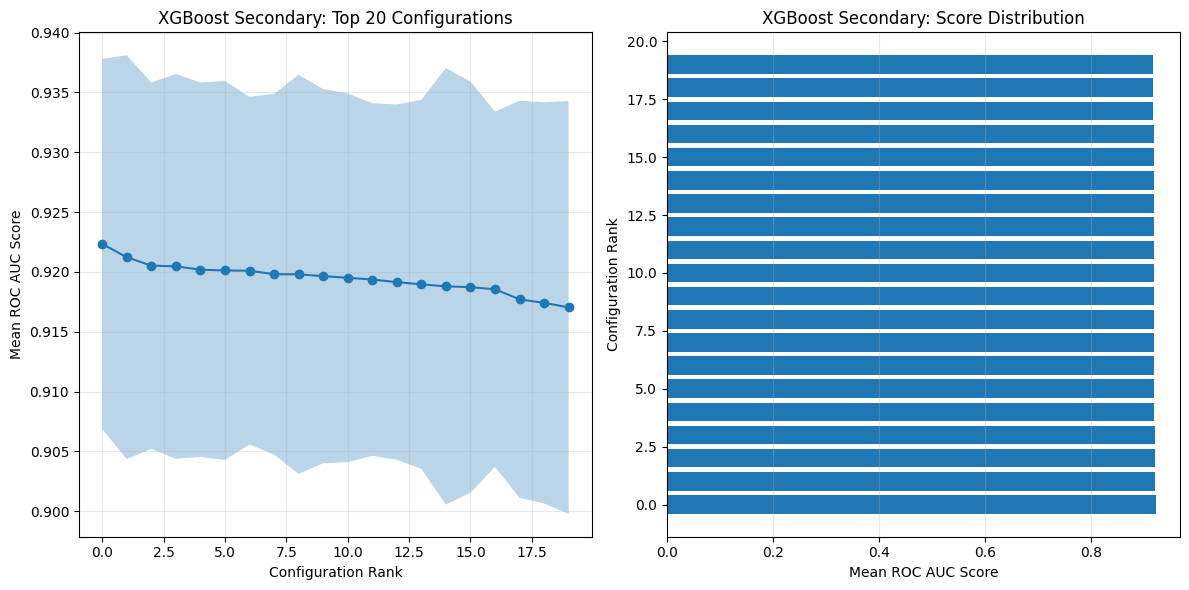


Feature Importance Analysis...


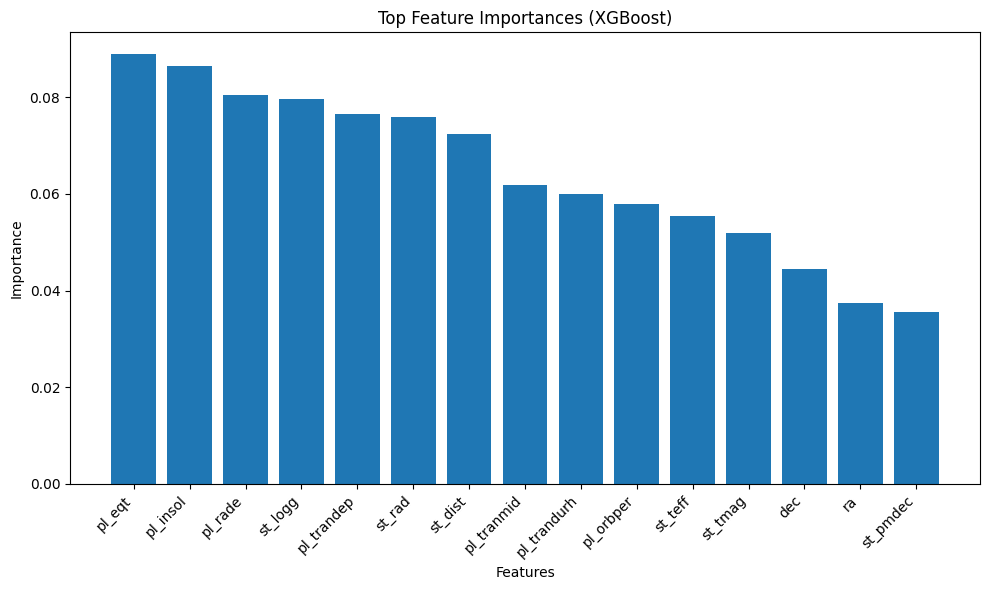


STEP 6: Stacking Ensemble
Training stacking classifier with XGBoost models...
✓ Stacking model trained

STEP 7: Validation Evaluation

Validation Metrics
Accuracy : 0.842
Precision: 0.826
Recall   : 0.862
F1 Score : 0.844
ROC AUC  : 0.924
Brier    : 0.113

Confusion Matrix:
  TN:  213  |  FP:   46
  FN:   35  |  TP:  219

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       259
           1       0.83      0.86      0.84       254

    accuracy                           0.84       513
   macro avg       0.84      0.84      0.84       513
weighted avg       0.84      0.84      0.84       513


Generating learning curves...


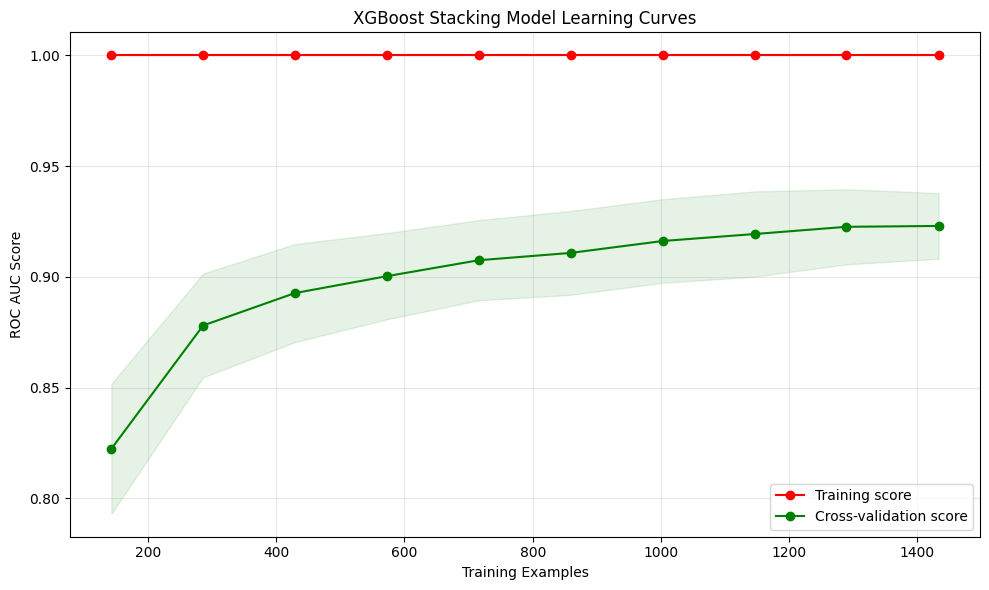


STEP 8: Final Model Training
Training final XGBoost ensemble on train+val data...
✓ Final model trained

STEP 9: Test Set Evaluation

Test Set Metrics
Accuracy : 0.875
Precision: 0.874
Recall   : 0.874
F1 Score : 0.874
ROC AUC  : 0.951
Brier    : 0.089

Confusion Matrix:
  TN:  114  |  FP:   16
  FN:   16  |  TP:  111

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       130
           1       0.87      0.87      0.87       127

    accuracy                           0.88       257
   macro avg       0.88      0.88      0.88       257
weighted avg       0.88      0.88      0.88       257


Comparing model performance...


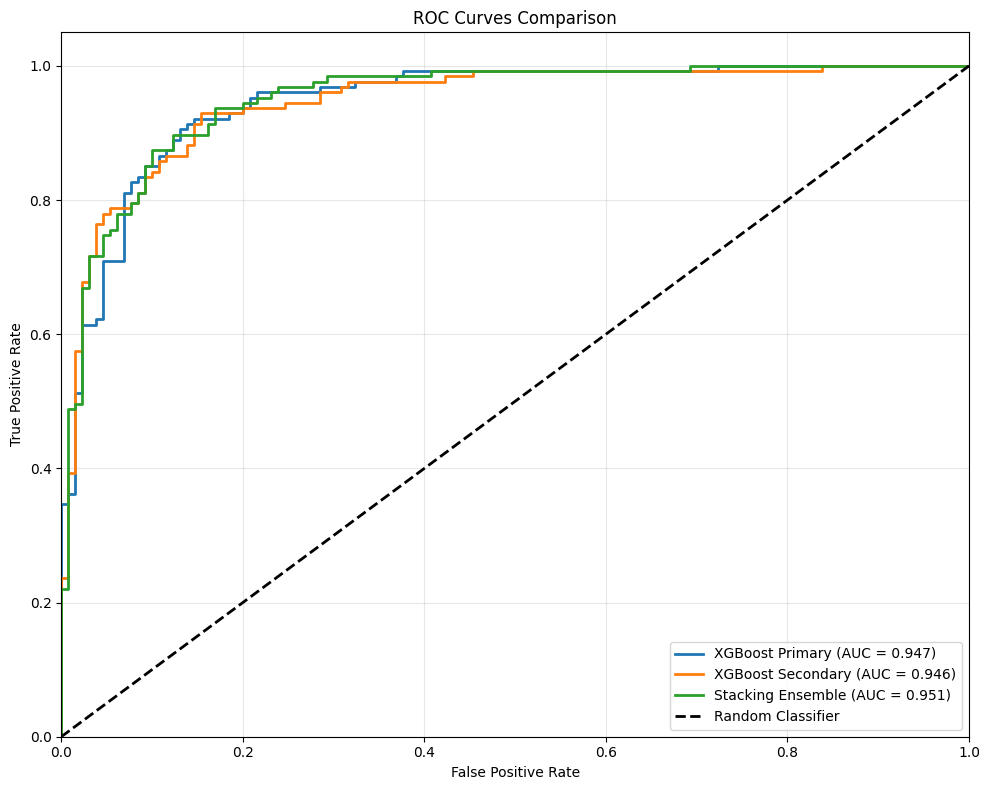


STEP 10: Save Model Pipeline
✅ Saved model pipeline to 'toi_xgboost_stacking_pipeline.joblib'

TRAINING COMPLETE - SUMMARY
Model: XGBoost Stacking Ensemble
Features used: 16
Training samples: 1792
Validation samples: 513
Test samples: 257

Final Test Performance:
  ROC AUC: 0.951
  F1 Score: 0.874
  Accuracy: 0.875


In [ ]:
# -*- coding: utf-8 -*-
"""Enhanced TOI Exoplanet Classifier with XGBoost and Training Visualization"""

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import joblib
import re

# Modeling + ML
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    brier_score_loss, roc_curve, auc
)
from xgboost import XGBClassifier

# Settings
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
pd.set_option("display.max_columns", 100)

# ============ CONFIGURATION ============
# Features to use for training
FEATURES = [
    'pl_orbper',    # Orbital Period
    'pl_trandurh',   # Transit Duration
    'pl_rade',      # Candidate Radius
    'st_dist',      # Distance to system
    'st_pmdec',     # Proper Motion (Dec)
    'st_pmra',      # Proper Motion (RA)
    'dec',          # Declination
    'pl_insol',     # Insolation Flux
    'pl_tranmid',   # Transit Midpoint
    'ra',           # Right Ascension
    'st_tmag',      # TESS Magnitude
    'pl_trandep',   # Transit Depth
    'pl_eqt',       # Equilibrium Temperature
    'st_rad',
    'st_logg',      # Stellar Surface Gravity
    'st_teff'       # Effective Temperature
]

LABEL_COL = 'tfopwg_disp'  # Disposition column
USER_URL = 'https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+toi+where+tfopwg_disp=%27CP%27&format=csv'
FALLBACK_URL = 'https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+toi&format=csv'

# ============ HELPER FUNCTIONS ============
def fetch_csv(url):
    print(f"Downloading from:\n  {url[:80]}...")
    df = pd.read_csv(url)
    print(f" -> Got {df.shape[0]} rows, {df.shape[1]} cols")
    return df


def map_disp_to_label(s):
    """Map disposition string to binary label."""
    if pd.isna(s):
        return np.nan
    su = str(s).upper()
    if "CONFIRMED" in su or su.strip() == "CP" or su.strip() == "KP":
        return 1
    if "FALSE" in su or su.strip() == "FP" or su.strip() == "FA":
        return 0
    return np.nan


def print_class_balance(y, label="data"):
    vals, counts = np.unique(y, return_counts=True)
    print(f"\nClass balance ({label}):")
    for v, c in zip(vals, counts):
        print(f"  {v}: {c} ({c/len(y):.1%})")


def plot_learning_curves(estimator, X, y, title="Learning Curves", cv=5):
    """Plot learning curves to visualize training progress."""
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='roc_auc', random_state=RANDOM_SEED
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, val_mean, 'o-', color='g', label='Cross-validation score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')

    plt.xlabel('Training Examples')
    plt.ylabel('ROC AUC Score')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_roc_curves(models_dict, X_test, y_test):
    """Plot ROC curves for multiple models."""
    plt.figure(figsize=(10, 8))

    for name, model in models_dict.items():
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_feature_importance(model, feature_names, top_n=15):
    """Plot feature importance for the best XGBoost model."""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:top_n]

        plt.figure(figsize=(10, 6))
        plt.title('Top Feature Importances (XGBoost)')
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()


def plot_training_history(rs_model, model_name="Model"):
    """Plot hyperparameter search results."""
    results = pd.DataFrame(rs_model.cv_results_)
    results = results.sort_values('mean_test_score', ascending=False).head(20)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(results)), results['mean_test_score'], 'o-')
    plt.fill_between(range(len(results)),
                     results['mean_test_score'] - results['std_test_score'],
                     results['mean_test_score'] + results['std_test_score'],
                     alpha=0.3)
    plt.xlabel('Configuration Rank')
    plt.ylabel('Mean ROC AUC Score')
    plt.title(f'{model_name}: Top 20 Configurations')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.barh(range(len(results)), results['mean_test_score'])
    plt.xlabel('Mean ROC AUC Score')
    plt.ylabel('Configuration Rank')
    plt.title(f'{model_name}: Score Distribution')
    plt.grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()


def evaluate_model(y_true, y_pred, y_proba, tag="Validation"):
    """Evaluate model and print metrics."""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred)
    auc_ = roc_auc_score(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n{'='*50}")
    print(f"{tag} Metrics")
    print('='*50)
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1 Score : {f1:.3f}")
    print(f"ROC AUC  : {auc_:.3f}")
    print(f"Brier    : {brier:.3f}")
    print(f"\nConfusion Matrix:")
    print(f"  TN: {cm[0,0]:4d}  |  FP: {cm[0,1]:4d}")
    print(f"  FN: {cm[1,0]:4d}  |  TP: {cm[1,1]:4d}")
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred))
    return dict(acc=acc, prec=prec, rec=rec, f1=f1, auc=auc_, brier=brier)


# ============ DATA LOADING ============
print("="*60)
print("STEP 1: Data Loading and Preprocessing")
print("="*60)

df = fetch_csv(FALLBACK_URL)

if LABEL_COL not in df.columns:
    raise ValueError(f"Column {LABEL_COL} not found.")

# Map label
df["label_raw"] = df[LABEL_COL]
df["label"] = df["label_raw"].apply(map_disp_to_label)

# Check available features
available_features = [f for f in FEATURES if f in df.columns]
missing_features = [f for f in FEATURES if f not in df.columns]

if missing_features:
    print(f"\n⚠️  Warning: Missing features: {missing_features}")
    print(f"✓  Using {len(available_features)} available features")
    FEATURES = available_features

# Keep only numeric columns + label
df = df[FEATURES + ["label"]]
df = df.apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=["label"])
df = df.dropna(how="all", subset=FEATURES).reset_index(drop=True)

print(f"\nFinal cleaned dataset: {df.shape}")
print_class_balance(df["label"], "Full dataset")

# ============ TRAIN/VAL/TEST SPLIT ============
print("\n" + "="*60)
print("STEP 2: Data Splitting")
print("="*60)

X = df[FEATURES]
y = df["label"].astype(int)

# First split test (10%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_SEED, stratify=y
)

# Then split validation (20% of total)
val_frac = 0.2 / 0.9
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_frac, random_state=RANDOM_SEED, stratify=y_trainval
)

print(f"\nTrain: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val:   {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test:  {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print_class_balance(y_train, "Train")
print_class_balance(y_val, "Val")
print_class_balance(y_test, "Test")

# ============ PREPROCESSING ============
print("\n" + "="*60)
print("STEP 3: Preprocessing")
print("="*60)

preprocessor = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

X_train_p = preprocessor.fit_transform(X_train)
X_val_p = preprocessor.transform(X_val)
X_test_p = preprocessor.transform(X_test)
print("✓ Data preprocessed (imputation + scaling)")

# ============ MODEL TRAINING ============
print("\n" + "="*60)
print("STEP 4: Hyperparameter Tuning")
print("="*60)

# XGBoost tuning (primary model)
print("\n[1/2] Tuning XGBoost...")
param_xgb = {
    "n_estimators": [800,1600],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7, 10, 20],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.2],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [1, 1.5, 2],
}
xgb = XGBClassifier(
    random_state=RANDOM_SEED,
    eval_metric='logloss',
    use_label_encoder=False,
    tree_method='hist'
)
rs_xgb = RandomizedSearchCV(
    xgb, param_distributions=param_xgb, n_iter=100,
    scoring="roc_auc", cv=5, random_state=RANDOM_SEED, n_jobs=-1, verbose=1
)
rs_xgb.fit(X_train_p, y_train)
best_xgb = rs_xgb.best_estimator_
print(f"\n✓ Best XGBoost ROC AUC: {rs_xgb.best_score_:.3f}")
print("Best XGBoost params:")
pprint(rs_xgb.best_params_)

# Secondary XGBoost with different parameters (for ensemble diversity)
print("\n[2/2] Tuning Secondary XGBoost...")
param_xgb2 = {
    "n_estimators": [ 300, 600],
    "learning_rate": [0.02, 0.07, 0.15],
    "max_depth": [4, 6, 8],
    "min_child_weight": [2, 4],
    "subsample": [0.75, 0.85, 0.95],
    "colsample_bytree": [0.75, 0.85, 0.95],
}
xgb2 = XGBClassifier(
    random_state=RANDOM_SEED + 1,
    eval_metric='logloss',
    use_label_encoder=False,
    tree_method='hist'
)
rs_xgb2 = RandomizedSearchCV(
    xgb2, param_distributions=param_xgb2, n_iter=20,
    scoring="roc_auc", cv=5, random_state=RANDOM_SEED + 1, n_jobs=-1, verbose=1
)
rs_xgb2.fit(X_train_p, y_train)
best_xgb2 = rs_xgb2.best_estimator_
print(f"\n✓ Best Secondary XGBoost ROC AUC: {rs_xgb2.best_score_:.3f}")
print("Best Secondary XGBoost params:")
pprint(rs_xgb2.best_params_)

# ============ VISUALIZATION: TRAINING PROCESS ============
print("\n" + "="*60)
print("STEP 5: Training Visualization")
print("="*60)

# Plot hyperparameter search results
plot_training_history(rs_xgb, "XGBoost Primary")
plot_training_history(rs_xgb2, "XGBoost Secondary")

# Plot feature importance
print("\nFeature Importance Analysis...")
plot_feature_importance(best_xgb, FEATURES)

# ============ STACKING ENSEMBLE ============
print("\n" + "="*60)
print("STEP 6: Stacking Ensemble")
print("="*60)

stack = StackingClassifier(
    estimators=[("xgb1", best_xgb), ("xgb2", best_xgb2)],
    final_estimator=LogisticRegression(max_iter=5000),
    n_jobs=-1,
    cv=5
)
print("Training stacking classifier with XGBoost models...")
stack.fit(X_train_p, y_train)
print("✓ Stacking model trained")

# ============ VALIDATION EVALUATION ============
print("\n" + "="*60)
print("STEP 7: Validation Evaluation")
print("="*60)

y_val_pred = stack.predict(X_val_p)
y_val_proba = stack.predict_proba(X_val_p)[:, 1]
val_metrics = evaluate_model(y_val, y_val_pred, y_val_proba, "Validation")

# Plot learning curves
print("\nGenerating learning curves...")
plot_learning_curves(stack, X_train_p, y_train, "XGBoost Stacking Model Learning Curves")

# ============ FINAL MODEL TRAINING ============
print("\n" + "="*60)
print("STEP 8: Final Model Training")
print("="*60)

# Combine train + val
X_trainval_p = np.vstack([X_train_p, X_val_p])
y_trainval = np.concatenate([y_train, y_val])

stack_final = StackingClassifier(
    estimators=[("xgb1", best_xgb), ("xgb2", best_xgb2)],
    final_estimator=LogisticRegression(max_iter=50000),
    n_jobs=-1,
    cv=5
)
print("Training final XGBoost ensemble on train+val data...")
stack_final.fit(X_trainval_p, y_trainval)
print("✓ Final model trained")

# ============ TEST EVALUATION ============
print("\n" + "="*60)
print("STEP 9: Test Set Evaluation")
print("="*60)

y_test_pred = stack_final.predict(X_test_p)
y_test_proba = stack_final.predict_proba(X_test_p)[:, 1]
test_metrics = evaluate_model(y_test, y_test_pred, y_test_proba, "Test Set")

# Plot ROC curves comparison
print("\nComparing model performance...")
models_dict = {
    'XGBoost Primary': best_xgb,
    'XGBoost Secondary': best_xgb2,
    'Stacking Ensemble': stack_final
}
plot_roc_curves(models_dict, X_test_p, y_test)

# ============ SAVE MODEL ============
print("\n" + "="*60)
print("STEP 10: Save Model Pipeline")
print("="*60)

final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", stack_final)
])

joblib.dump(final_pipeline, "toi_xgboost_stacking_pipeline.joblib")
print("✅ Saved model pipeline to 'toi_xgboost_stacking_pipeline.joblib'")

# Print summary
print("\n" + "="*60)
print("TRAINING COMPLETE - SUMMARY")
print("="*60)
print(f"Model: XGBoost Stacking Ensemble")
print(f"Features used: {len(FEATURES)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"\nFinal Test Performance:")
print(f"  ROC AUC: {test_metrics['auc']:.3f}")
print(f"  F1 Score: {test_metrics['f1']:.3f}")
print(f"  Accuracy: {test_metrics['acc']:.3f}")
print("="*60)